In [1]:
import numpy as np
from netCDF4 import Dataset
import cartopy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import wrf

In [2]:
import torch

In [3]:
torch.__version__

'1.10.2'

In [4]:
# Load netcdf file
data_dir = './'
wrf_filename = '%straining.nc' % data_dir
ncf = Dataset(wrf_filename, "r", format="NETCDF4")

In [5]:
target_cols = [
    'ccn_001',
     'ccn_003',
     'ccn_006',
     'CHI',
     'CHI_CCN',
     'D_ALPHA',
     'D_GAMMA',
     'D_ALPHA_CCN',
     'D_GAMMA_CCN',
     'PM25'
]

In [6]:
#https://discuss.pytorch.org/t/how-to-use-netcdf-data-for-dcgan/124870/3?msclkid=560cbb7ec28511ec8730e27933a5095c
# https://discuss.pytorch.org/t/problems-using-dataloader-for-dask-xarray-netcdf-data/108270
class AEDataset(torch.utils.data.Dataset):
    def __init__(self,filename,target):
        super().__init__()
        self.ncf = Dataset(filename, "r", format="NETCDF4")
        self.target = target
    def __getitem__(self,idx):
        out = np.zeros((1, len(self.target)))
        for i,t in enumerate(self.target):
            out[:,i] = self.ncf[t][0,idx,0,0]
        return out
    def __len__(self):
        return 132

In [8]:
with open('x_gases.txt', 'r') as f:
    gases = f.read().splitlines() 

with open('x_aerosols.txt', 'r') as f:
    aerosols = f.read().splitlines() 

In [9]:
ds = AEDataset(wrf_filename, gases)

In [10]:
from torch.utils.data import DataLoader

In [11]:
dl = DataLoader(ds, batch_size=32)

In [12]:
%%timeit
next(iter(dl))

706 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
from torch.utils.data import TensorDataset

In [14]:
ds = TensorDataset(x)

NameError: name 'x' is not defined

# Indexer

In [22]:
class Indexer:
    def __init__(self, ndims):
        self.ndims = ndims
    def idx4(self, a):
        t, k, j, i = a
        nt, nz, ny, nx = self.ndims
        return ((nz*t + k)*ny + j)*nx + i
    def inverse4(self, ix):
        nt, nz, ny, nx = self.ndims
        total = nz*ny*nx
        t = ix// total
        ix = ix % total
        
        total = ny*nx
        k = ix // total
        ix = ix % total
        
        total = nx
        j = ix//total
        i = ix % total
        return (t,k,j,i)
idxer = Indexer(ncf.variables['ccn_001'].shape)

In [25]:
ncf.variables['ccn_001'].shape

(133, 39, 159, 169)

In [27]:
# 20 timesteps
NMAX = 20 * 39 * 159 * 169

NMAX

20959380

In [7]:
feat_cols = ['TOT_NUM_CONC',
 'TOT_MASS_CONC',
 'pmc_SO4',
 'pmc_NO3',
 'pmc_Cl',
 'pmc_NH4',
 'pmc_ARO1',
 'pmc_ARO2',
 'pmc_ALK1',
 'pmc_OLE1',
 'pmc_API1',
 'pmc_API2',
 'pmc_LIM1',
 'pmc_LIM2',
 'pmc_OC',
 'pmc_BC',
 'pmc_H2O',
 'TEMPERATURE',
 'REL_HUMID',
 'ALT',
 'Z',
#  'XLAT',
#  'XLONG',
 'h2so4',
 'hno3',
 'hcl',
 'nh3',
 'no',
 'no2',
 'no3',
 'n2o5',
 'hono',
 'hno4',
 'o3',
 'o1d',
 'O3P',
 'oh',
 'ho2',
 'h2o2',
 'co',
 'so2',
 'ch4',
 'c2h6',
 'ch3o2',
 'ethp',
 'hcho',
 'ch3oh',
 'ANOL',
 'ch3ooh',
 'ETHOOH',
 'ald2',
 'hcooh',
 'RCOOH',
 'c2o3',
 'pan',
 'aro1',
 'aro2',
 'alk1',
 'ole1',
 'api1',
 'api2',
 'lim1',
 'lim2',
 'par',
 'AONE',
 'mgly',
 'eth',
 'OLET',
 'OLEI',
 'tol',
 'xyl',
 'cres',
 'to2',
 'cro',
 'open',
 'onit',
 'rooh',
 'ro2',
 'ano2',
 'nap',
 'xo2',
 'xpar',
 'isop',
 'isoprd',
 'isopp',
 'isopn',
 'isopo2',
 'api',
 'lim',
 'dms',
 'msa',
 'dmso',
 'dmso2',
 'ch3so2h',
 'ch3sch2oo',
 'ch3so2',
 'ch3so3',
 'ch3so2oo',
 'ch3so2ch2oo',
 'SULFHOX',
 'P',
 'PB']

In [8]:
class RegDataset(torch.utils.data.Dataset):
    def __init__(self,filename,features,target):
        super().__init__()
        self.ncf = Dataset(filename, "r", format="NETCDF4")
        self.target = target
        self.feat   = features
        self.ixer   = idxer = Indexer(ncf.variables['ccn_001'].shape)
        
    def __getitem__(self,idx):
        ix4 = self.ixer.inverse4(idx)
#         print(ix4)
        feat= np.zeros((1, len(self.feat)))
        for i,t in enumerate(self.feat):
            feat[:,i] = self.ncf[t][ix4]
        
        out = np.zeros((1, len(self.target)))
        for i,t in enumerate(self.target):
            out[:,i] = self.ncf[t][ix4]
        return feat, out
    def __len__(self):
        return NMAX

In [9]:
class RegDataset(torch.utils.data.Dataset):
    def __init__(self,filename,features,target):
        super().__init__()
        self.ncf = Dataset(filename, "r", format="NETCDF4")
        self.target = target
        self.feat   = features
        self.ixer   = idxer = Indexer(ncf.variables['ccn_001'].shape)
        
    def __getitem__(self,idx):
        ix4 = self.ixer.inverse4(idx)
#         print(ix4)
        feat= np.zeros((len(self.feat)))
        for i,t in enumerate(self.feat):
            feat[i] = self.ncf[t][ix4]
        
        out = np.zeros((len(self.target)))
        for i,t in enumerate(self.target):
            out[i] = self.ncf[t][ix4]
        return feat, out
    def __len__(self):
        return NMAX

In [141]:
NMAX

20959380

In [142]:
idxes = np.random.randint(0,NMAX,16)

In [144]:
ds = RegDataset(wrf_filename, feat_cols, target_cols)
dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True,num_workers=0)

In [143]:
%%time
for i in idxes:
    ds[i]

CPU times: user 652 ms, sys: 112 ms, total: 764 ms
Wall time: 2.48 s


In [149]:
len(dl) * 4 / 60/60/24

60.646388888888886

In [145]:
%%time
next(iter(dl))

CPU times: user 1.82 s, sys: 272 ms, total: 2.09 s
Wall time: 4.35 s


[tensor([[2.1145e+08, 6.3599e-10, 3.2515e-10,  ..., 2.6074e-07, 9.0165e+02,
          8.3721e+04],
         [3.1073e+07, 4.4897e-11, 2.1782e-11,  ..., 1.0000e-16, 4.4123e+00,
          5.2840e+03],
         [4.7268e+07, 2.1350e-10, 8.0567e-11,  ..., 1.0000e-16, 2.9568e+02,
          2.4014e+04],
         ...,
         [7.8487e+07, 3.4612e-10, 1.2622e-10,  ..., 8.5891e-15, 6.0368e+02,
          4.9672e+04],
         [2.7647e+07, 3.6995e-11, 1.7507e-11,  ..., 1.0000e-16, 4.2824e+00,
          5.2053e+03],
         [5.6262e+07, 2.0252e-10, 7.8007e-11,  ..., 1.0000e-16, 2.3199e+02,
          2.0955e+04]], dtype=torch.float64),
 tensor([[1.8411e+07, 5.3832e+07, 7.9168e+07, 6.8384e-01, 6.9186e-01, 2.6172e+00,
          3.3648e+00, 1.4379e+00, 1.6330e+00, 3.6685e-10],
         [6.9810e+05, 2.5691e+06, 4.7254e+06, 7.0322e-01, 7.7905e-01, 2.1313e+00,
          2.6087e+00, 1.4088e+00, 1.5248e+00, 3.0336e-11],
         [1.8435e+06, 9.8547e+06, 1.4669e+07, 7.4810e-01, 7.4376e-01, 1.9584e+00,
     

In [106]:
# %%time
import time
time_now = time.time()
counts = 0
for feat, out in dl:
    print(time.time() - time_now)
    time_now = time.time()
    if counts > 100: break
    counts += 1

5.84761643409729
5.494378328323364
5.3465735912323
5.30994725227356
5.668700695037842
4.7315380573272705
5.056265830993652
5.5845935344696045
5.248762607574463
5.3059399127960205
4.850856781005859
4.971888780593872
4.755682468414307


KeyboardInterrupt: 

In [123]:
# %%time
log_mean = {}
log_std  = {}
for f in target_cols:
    tmp = np.log(ds.ncf[f])
    log_mean[f] = tmp.mean()
    log_std[f]  = tmp.std()
    
for f in feat_cols:
    tmp = np.log(ds.ncf[f])
    log_mean[f] = tmp.mean()
    log_std[f]  = tmp.std()

/tmp/ipykernel_599759/2103884522.py:10: RuntimeWarning: divide by zero encountered in log
  tmp = np.log(ds.ncf[f])
/home/kwoksun2/.conda/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_599759/2103884522.py:10: RuntimeWarning: invalid value encountered in log
  tmp = np.log(ds.ncf[f])


/tmp/ipykernel_599759/3608747556.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(ds.ncf['pmc_NO3'][30,0,:,:]))


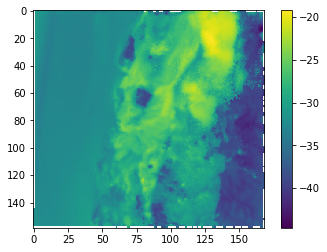

In [136]:
plt.imshow(np.log(ds.ncf['pmc_NO3'][30,0,:,:]))
plt.colorbar()

In [128]:
ds.ncf['pmc_NO3']

<class 'netCDF4._netCDF4.Variable'>
float32 pmc_NO3(Time, bottom_top, south_north, west_east)
    FieldType: 104
    MemoryOrder: XYZ
    description: NO3, total mass
    units: total mass
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (133, 39, 159, 169)
filling on, default _FillValue of 9.969209968386869e+36 used

In [124]:
log_mean, log_std

({'ccn_001': 15.125228,
  'ccn_003': 16.548517,
  'ccn_006': 16.995298,
  'CHI': -0.34824014,
  'CHI_CCN': -0.3262838,
  'D_ALPHA': 0.73368394,
  'D_GAMMA': 0.92895013,
  'D_ALPHA_CCN': 0.346326,
  'D_GAMMA_CCN': 0.45309588,
  'PM25': -22.556446,
  'TOT_NUM_CONC': 18.34305,
  'TOT_MASS_CONC': -22.136595,
  'pmc_SO4': -22.968529,
  'pmc_NO3': -inf,
  'pmc_Cl': -inf,
  'pmc_NH4': -inf,
  'pmc_ARO1': -inf,
  'pmc_ARO2': -inf,
  'pmc_ALK1': -inf,
  'pmc_OLE1': -inf,
  'pmc_API1': -25.16306,
  'pmc_API2': -inf,
  'pmc_LIM1': -inf,
  'pmc_LIM2': -inf,
  'pmc_OC': -24.806288,
  'pmc_BC': -25.524881,
  'pmc_H2O': -inf,
  'TEMPERATURE': 5.5034914,
  'REL_HUMID': -1.5752105,
  'ALT': 0.84901726,
  'Z': nan,
  'h2so4': -12.644124,
  'hno3': -1.6351258,
  'hcl': -30.56432,
  'nh3': -15.9323015,
  'no': -9.122495,
  'no2': -2.6634173,
  'no3': -10.187049,
  'n2o5': -7.1586,
  'hono': -10.355517,
  'hno4': -5.1955643,
  'o3': 4.7586384,
  'o1d': -inf,
  'O3P': -inf,
  'oh': -11.8316765,
  'ho2': -7.

In [120]:
!du -h ccn001.npy

532M	ccn001.npy


In [9]:
%%timeit
dd = []
x = next(iter(dl))
indices = [ idx.inverse4(i) for i in x.numpy()]

out = np.zeros((len(target_cols), 128))
for j, t in enumerate(target_cols):
    for i, ix in enumerate(indices):
        out[j,i] = ncf.variables[t][ix].data.item()

NameError: name 'dl' is not defined

In [27]:
ncf.variables['PM25'][indices[0]]

masked_array(data=2.637307e-10,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [1]:
tmp[:,0]

NameError: name 'tmp' is not defined

In [19]:
150*150*150*150* 8 / 1024 / 1024 / 1024

3.771856427192688

In [20]:
class AEDataset:
    def __init__(self,filename,target):
        super().__init__()
        self.ncf = Dataset(filename, "r", format="NETCDF4")
        self.target = target
    def __getitem__(self,idx):
        out = np.zeros((1, len(self.target)))
        for i,t in enumerate(self.target):
            out[:,i] = self.ncf[t][]
        return out
    def __len__(self):
        return 132

SyntaxError: invalid syntax (3977600041.py, line 9)